In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd 
import seaborn as sns 
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from ydata_profiling import ProfileReport

In [4]:
%matplotlib inline

In [5]:
modeldf2019 = pd.read_csv('mydata/MMSA2019_train.csv')
modeldf2021 = pd.read_csv('mydata/MMSA2021_train.csv')

In [6]:
#pd.set_option('display.max_columns', None)

In [7]:
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000000)

In [8]:
import io
buffer = io.StringIO()
modeldf2019.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140514 entries, 0 to 140513
Data columns (total 180 columns):
 #    Column      Non-Null Count   Dtype  
---   ------      --------------   -----  
 0    Unnamed: 0  140514 non-null  int64  
 1    DISPCODE    140514 non-null  int64  
 2    STATERE1    47593 non-null   float64
 3    CELPHONE    47593 non-null   float64
 4    LADULT1     47593 non-null   float64
 5    COLGSEX     11 non-null      float64
 6    LANDSEX     20189 non-null   float64
 7    RESPSLCT    24008 non-null   float64
 8    SAFETIME    92921 non-null   float64
 9    CADULT1     92921 non-null   float64
 10   CELLSEX     92917 non-null   float64
 11   HHADULT     92918 non-null   float64
 12   SEXVAR      140514 non-null  int64  
 13   GENHLTH     140501 non-null  float64
 14   PHYSHLTH    140503 non-null  float64
 15   MENTHLTH    140508 non-null  float64
 16   POORHLTH    77558 non-null   float64
 17   HLTHPLN1    140510 non-null  float64
 18   PERSDOC2    140511 non

In [9]:
buffer = io.StringIO()
modeldf2021.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151861 entries, 0 to 151860
Data columns (total 152 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  151861 non-null  float64
 1    STATERE1  37094 non-null   float64
 2    CELPHON1  37094 non-null   float64
 3    LADULT1   37094 non-null   float64
 4    COLGSEX   13 non-null      float64
 5    LANDSEX   15568 non-null   float64
 6    RESPSLCT  20603 non-null   float64
 7    SAFETIME  114767 non-null  float64
 8    CADULT1   114767 non-null  float64
 9    CELLSEX   114766 non-null  float64
 10   HHADULT   114766 non-null  float64
 11   SEXVAR    151861 non-null  float64
 12   GENHLTH   151860 non-null  float64
 13   PHYSHLTH  151859 non-null  float64
 14   MENTHLTH  151861 non-null  float64
 15   POORHLTH  81991 non-null   float64
 16   PRIMINSR  151860 non-null  float64
 17   PERSDOC3  151861 non-null  float64
 18   MEDCOST1  151860 non-null  float64
 19   CHECKUP1  151861 non-

In [10]:
#Merge dataframes

In [11]:
#Fill missing values of extra columns with current categorical values to keep ratio randomnly 

In [12]:
#Handle missing data 

### Merging 2019 and 2021 BRFSS Dataframes Using Columns of Interest

In [13]:
#Any variable with value counts below 14 with be turned to a categorical nominal datatype:
# Convert 'col1' from float to categorical
for col in modeldf2019.columns:
    if len(modeldf2019[col].value_counts()) < 15:
        modeldf2019[col] = modeldf2019[col].astype('category')
        
for col in modeldf2021.columns:
    if len(modeldf2021[col].value_counts()) < 15:
        modeldf2021[col] = modeldf2021[col].astype('category')
               

In [14]:
##Extract state from MMSANAME
def get_state(col):
    return col.split(',')[1]

modeldf2019['STATE'] = modeldf2019['MMSANAME'].apply(get_state)
modeldf2021['STATE'] = modeldf2021['MMSANAME'].apply(get_state)

In [15]:
columns = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1', '_HLTHPLN','PRIMINSR', '_RACE', 'MEDCOST1', 'MARITAL', '_EDUCAG', 
                'RENTHOM1', 'EMPLOY1', 'CHILDREN', '_INCOMG1', '_TOTINDA', 'CHCOCNCR', 'SMOKE100', 
                'SMOKDAY2', 'USENOW3','_SMOKER3', '_RFSMOK3','_RFBING5', 'DIABETE4', 
                'CHCOCNCR', '_MICHD', '_RFHYPE6', '_RFCHOL3', 'ADDEPEV3', 'DECIDE','_AGE65YR', 
                'WTKG3', '_BMI5', '_BMI5CAT', '_SEX','STATE','SEQNO','_RFHLTH']
len(columns)

41

In [16]:
#RENAME COLUMNS in 2019 dataset to match 2021:
modeldf2019.rename(columns={'_INCOMG':'_INCOMG1','_RFHYPE5':'_RFHYPE6','HLTHPLN1': 'PRIMINSR','MEDCOST':'MEDCOST1',
                  '_RFCHOL2':'_RFCHOL3'},inplace=True)

In [17]:
#Create a _HLTHPLN from PRIMINSR IN 2019 df (- '_HLTHPLN' - Categorical variable for healthcare plan )

modeldf2019['_HLTHPLN'] = modeldf2019['PRIMINSR'].apply(lambda x: 1 if x in [1,2,3,4,5,6,7,8,9] 
                                                        else 2 if x == 88 else 'NA')

modeldf2019['_TOTINDA'] = modeldf2019['_TOTINDA'].astype(float)

#Create a DROCDY3_ from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month
def compute_drocdy3_(x):
    # Handle NaN values
    if pd.isna(x):
        return np.nan
    
    x_int = int(str(x).split(".")[0])
    
    if x_int == 888:
        return 0.0
    elif x_int // 100 == 1:
        return (x_int % 100) / 7.0
    elif x_int // 100 == 2:
        return (x_int % 100) / 30.0
    elif x_int in [777, 999]:
        return np.nan
    else:
        return float(x_int)

modeldf2021['DROCDY3_'] = modeldf2019['ALCDAY5'].apply(compute_drocdy3_)

In [18]:
#Make a df of selected variables for 2019 and 2021
modeldf2019_2 = modeldf2019[columns]
modeldf2021_2 = modeldf2021[columns]

In [19]:
model_df = pd.concat([modeldf2019_2,modeldf2021_2])

In [20]:
model_df.head()

,FRNCHDA_,POTADA1_,FRUTDA2_,FTJUDA2_,VEGEDA2_,GRENDA1_,_FRUTSU1,_VEGESU1,_HLTHPLN,PRIMINSR,...,ADDEPEV3,DECIDE,_AGE65YR,WTKG3,_BMI5,_BMI5CAT,_SEX,STATE,SEQNO,_RFHLTH
0,0.0,0.0,100.0,33.0,50.0,50.0,133.0,100.0,1.0,1.0,...,1.0,2.0,1.0,11294.0,3786.0,4.0,1.0,WI,2.019001e+09,1.0
1,0.0,10.0,200.0,0.0,14.0,29.0,200.0,53.0,1.0,1.0,...,2.0,2.0,2.0,11113.0,3232.0,4.0,1.0,IA-NE-SD,2.019000e+09,1.0
2,0.0,14.0,200.0,0.0,100.0,100.0,200.0,214.0,1.0,1.0,...,2.0,2.0,2.0,13154.0,3723.0,4.0,1.0,FL,2.019000e+09,1.0
3,10.0,10.0,0.0,0.0,100.0,13.0,0.0,133.0,1.0,1.0,...,2.0,2.0,1.0,6895.0,2969.0,3.0,2.0,RI-MA,2.019003e+09,1.0
4,43.0,29.0,14.0,0.0,29.0,0.0,14.0,101.0,1.0,1.0,...,2.0,2.0,1.0,9072.0,3132.0,4.0,2.0,KS,2.019002e+09,1.0


In [21]:
#Lets make a copy of the merged dataframe
processed_features_df = model_df.copy()

#Place decimal place in fruit and vegetable columns (as it was implied)
def convert_decimal(x):
    if pd.isna(x):
        return np.nan
    else:
        return x/100
    
cols = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1','WTKG3','_BMI5']

#Convert features to appropriate values by placing the decimal place 
for col in cols:
    processed_features_df[col] = processed_features_df[col].apply(convert_decimal)

In [22]:
#Convert appropriate columns into categories
# List of columns to convert
columns_list = ['_AGE65YR', '_INCOMG1', '_TOTINDA', '_HLTHPLN', '_RFBING5', 
                'PRIMINSR', '_EDUCAG', '_SMOKER3','_RFSMOK3','_SEX', '_RFHYPE6']

# Convert each column to category data type in place
for col in columns_list:
    processed_features_df[col] = processed_features_df[col].astype('category')


In [23]:
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292375 entries, 0 to 151860
Data columns (total 41 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   FRNCHDA_  262098 non-null  float64 
 1   POTADA1_  259732 non-null  float64 
 2   FRUTDA2_  262705 non-null  float64 
 3   FTJUDA2_  262390 non-null  float64 
 4   VEGEDA2_  259252 non-null  float64 
 5   GRENDA1_  262418 non-null  float64 
 6   _FRUTSU1  258320 non-null  float64 
 7   _VEGESU1  252218 non-null  float64 
 8   _HLTHPLN  292371 non-null  category
 9   PRIMINSR  292370 non-null  category
 10  _RACE     292373 non-null  category
 11  MEDCOST1  292371 non-null  category
 12  MARITAL   292353 non-null  category
 13  _EDUCAG   292375 non-null  category
 14  RENTHOM1  292361 non-null  category
 15  EMPLOY1   289981 non-null  category
 16  CHILDREN  288326 non-null  float64 
 17  _INCOMG1  292375 non-null  category
 18  _TOTINDA  292375 non-null  category
 19  CHCOCNCR  292371 non-nu

### Generate EDA Report with Original Dataset

In [24]:
#profile = ProfileReport(modeldf2019)
#profile.to_file(output_file="mydata/EDA_Report_2019.html")

#profile = ProfileReport(modeldf2021)
#profile.to_file(output_file="mydata/EDA_Report_2021.html")

### Data Cleaning Handle Missing data

In [25]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
SMOKDAY2,184042,0.629472
_VEGESU1,40157,0.137348
_RFCHOL3,36044,0.123280
_FRUTSU1,34055,0.116477
VEGEDA2_,33123,0.113289
POTADA1_,32643,0.111648
_BMI5CAT,30513,0.104363
_BMI5,30513,0.104363
FRNCHDA_,30277,0.103555
FTJUDA2_,29985,0.102557


In [26]:
#Drop SMOKDDAY2 due to 60% missing values and _BMI5 (_BMI5CAT alreday categorizes the data)
processed_features_df.drop(columns=['SMOKDAY2','_BMI5'],inplace=True)

In [27]:
#Drop the rows where columns have less than 5% missing values 
#list of columns with less than 5% missing data 
col_less5miss = list(missing_data.index[missing_data['Percent'] < 0.05])
processed_features_df.dropna(subset=col_less5miss,inplace=True)


<Axes: >

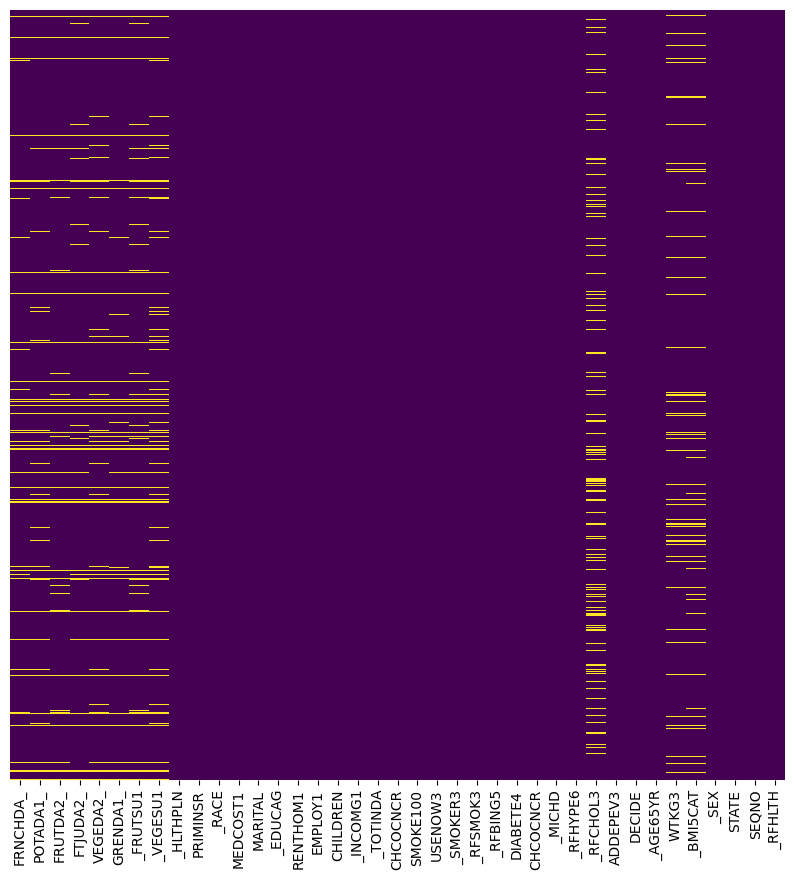

In [28]:
plt.figure(figsize=(10,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [ ]:
#Replace missing fruit and vegetable values with the median value for each race & Age category

In [ ]:
#replace BMI and Weight missing data with the median value for each race & Age category

## ANSWERING THE RESEARCH QUESTIONS 

How do dietary habits and nutrition shape an individual's health outcome?
- we know that studies have shown that high fiber intake is associated with lower mortality.
as seen in this comparative study https://pubmed.ncbi.nlm.nih.gov/22648726/. 
- we would like to see how a high vegetable/fruit diet may be associated with a person percieved health. 
- the darker the vegetables the higher the fibre content